# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Importing all necessary libraries and data

In [996]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

***

### Section 1 - Data wrangling and cleaning

First we need to take a look at the different datasets we were given and maybe perform some data wrangling and cleaning on it. This will help to prepare everything for further steps like analyzing the data and training models with it.

#### *The 'portfolio' dataset - Overview*

<u> contains offer ids and meta data about each offer (duration, type, etc.) </u>
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [997]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [998]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [999]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


#### *The 'portfolio' dataset - wrangling & cleaning*

Checking for missing data:

In [1000]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Checking for duplicates:

In [1001]:
portfolio.duplicated(subset=['id']).sum()

0

Now we need to get dummy variables for the 'channel' column, since all information regarding the channels used is stored in form of a list.

Getting all dummy variables out of the 'channels' column:

In [1002]:
channel_dummies = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).groupby(level=0).sum()

Concatenate them with the other columns, dropping the original 'channels' column dan storing it as a new dataframe:

In [1003]:
portfolio_df = pd.concat([portfolio, channel_dummies], axis=1).drop(columns=['channels'])

Renaming the 'id' column:

In [1004]:
portfolio_df.rename(columns={'difficulty':'required_expenditure','id':'offer_id'}, inplace=True)

In [1005]:
portfolio_df.head(10)

,reward,required_expenditure,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [1006]:
portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reward                10 non-null     int64 
 1   required_expenditure  10 non-null     int64 
 2   duration              10 non-null     int64 
 3   offer_type            10 non-null     object
 4   offer_id              10 non-null     object
 5   email                 10 non-null     uint8 
 6   mobile                10 non-null     uint8 
 7   social                10 non-null     uint8 
 8   web                   10 non-null     uint8 
dtypes: int64(3), object(2), uint8(4)
memory usage: 568.0+ bytes


In [1007]:
portfolio_df = portfolio_df.astype({'email':int,'mobile':int,'social':int,'web':int})

In [1008]:
portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reward                10 non-null     int64 
 1   required_expenditure  10 non-null     int64 
 2   duration              10 non-null     int64 
 3   offer_type            10 non-null     object
 4   offer_id              10 non-null     object
 5   email                 10 non-null     int64 
 6   mobile                10 non-null     int64 
 7   social                10 non-null     int64 
 8   web                   10 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 848.0+ bytes


#### *The 'profile' dataset - Overview*

<u> containts demographic data for each customer </u>
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [1009]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1010]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [1011]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


#### *The 'profile' dataset - wrangling & cleaning*

Renaming the 'id' column into 'customer_id'

In [1012]:
profile_df = profile.rename(columns={'id':'customer_id'})

Checking for duplicates:

In [1013]:
profile_df.duplicated(subset=['customer_id']).sum()

0

Since missing values in the 'age' column are encoded as 118 (int), we swap these values with NaN values:

In [1014]:
profile_df.loc[profile_df[profile_df.age == 118].index, 'age'] = np.nan

Checking for missing data:

In [1015]:
profile_df.isna().sum()

gender              2175
age                 2175
customer_id            0
became_member_on       0
income              2175
dtype: int64

In [1016]:
profile_df.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [1017]:
profile_df.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Check if all missing values are occurring in the same rows or if they are scattered over the entire dataframe: 

In [1018]:
profile_df[profile_df.gender.isna() & profile_df.income.isna() & profile_df.age.isna()].shape

(2175, 5)

In [1019]:
set(profile_df[profile_df.gender.isna()].index) - set(profile_df[profile_df.income.isna()].index) - set(profile_df[profile_df.age.isna()].index)

set()

It seems all missing values are in the same rows, which means we can separate the missing values very easy.

In [1020]:
(profile_df.age.isna().sum()/profile_df.shape[0])*100

12.794117647058822

So in total we have around 12% of our profile-data with missing values for the gender, age and income of the customer

In [1021]:
profile_df.head()

,gender,age,customer_id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1022]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


#### *The 'transcript' dataset - Overview*

<u> contains records for transactions, offers received, offers viewed, and offers completed </u>
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1023]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [1024]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [1025]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


#### *The 'transcript' dataset - wrangling & cleaning*

Renaming columns and store them in a new dataframe transcript_df

In [1026]:
transcript_df = transcript.rename(columns={'person':'customer_id'})

Checking for missing data:

In [1027]:
transcript_df.isna().sum()

customer_id    0
event          0
value          0
time           0
dtype: int64

Checking for duplicates:
Since this dataset represents data of events taking place, duplicates are valid.

The interesting part of this dataset is the events taking place with the corresponding event value, stored in the corresponding 'event' and 'value' columns:

In [1028]:
transcript_df.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Since the 'value' column stores the data in form of a dictionary, we need to get the keys of the dictionaries in a little bit more complicated way:

In [1029]:
value_keys = set().union(*transcript_df.value.apply(dict.keys))
value_keys

{'amount', 'offer id', 'offer_id', 'reward'}

Since there are 4 unique event values, as well as 4 unique value keys, it seems that the keys of the value dictionaries are unnecessary. So lets check if they are always the same depending on the event type:

In [1030]:
offer_received_key = set().union(*transcript_df[transcript_df.event == 'offer received']['value'].apply(dict.keys))
offer_viewed_key = set().union(*transcript_df[transcript_df.event == 'offer viewed']['value'].apply(dict.keys))
transaction_key = set().union(*transcript_df[transcript_df.event == 'transaction']['value'].apply(dict.keys))
offer_completed_key = set().union(*transcript_df[transcript_df.event == 'offer completed']['value'].apply(dict.keys))

print(f"""
    Corresponding value-keys for 'offer received'-event: {offer_received_key}
    Corresponding value-keys for 'offer viewed'-event: {offer_viewed_key}
    Corresponding value-keys for 'transaction'-event: {transaction_key}
    Corresponding value-keys for 'offer completed'-event: {offer_completed_key}
""")


    Corresponding value-keys for 'offer received'-event: {'offer id'}
    Corresponding value-keys for 'offer viewed'-event: {'offer id'}
    Corresponding value-keys for 'transaction'-event: {'amount'}
    Corresponding value-keys for 'offer completed'-event: {'offer_id', 'reward'}



Since 'offer id' and 'offer_id' are the same we name them both 'offer_id':

In [1031]:
transcript_df.value = transcript_df.value.apply(lambda x: {k.replace('offer id', 'offer_id'): v for k, v in x.items()})

Also the terms 'amount' and 'reward' describe both the amount transacted, distinguishable through the events 'transaction' and 'offer_completed'. So we rename them to 'total'.

In [1032]:
transcript_df.value = transcript_df.value.apply(lambda x: {k.replace('amount', 'total'): v for k, v in x.items()})
transcript_df.value = transcript_df.value.apply(lambda x: {k.replace('reward', 'total'): v for k, v in x.items()})

In [1033]:
offer_received_key = set().union(*transcript_df[transcript_df.event == 'offer received']['value'].apply(dict.keys))
offer_viewed_key = set().union(*transcript_df[transcript_df.event == 'offer viewed']['value'].apply(dict.keys))
transaction_key = set().union(*transcript_df[transcript_df.event == 'transaction']['value'].apply(dict.keys))
offer_completed_key = set().union(*transcript_df[transcript_df.event == 'offer completed']['value'].apply(dict.keys))

print(f"""
    Corresponding value-keys for 'offer received'-event: {offer_received_key}
    Corresponding value-keys for 'offer viewed'-event: {offer_viewed_key}
    Corresponding value-keys for 'transaction'-event: {transaction_key}
    Corresponding value-keys for 'offer completed'-event: {offer_completed_key}
""")


    Corresponding value-keys for 'offer received'-event: {'offer_id'}
    Corresponding value-keys for 'offer viewed'-event: {'offer_id'}
    Corresponding value-keys for 'transaction'-event: {'total'}
    Corresponding value-keys for 'offer completed'-event: {'offer_id', 'total'}



In [1034]:
transcript_df[transcript_df.event == 'offer completed'].value.apply(dict.keys).value_counts()

(offer_id, total)    33579
Name: value, dtype: int64

In [1035]:
transcript_df_o_c = transcript_df.loc[transcript_df.event == 'offer completed',:]
transcript_df_o_c.iloc[2,:].value

{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'total': 5}

So as we see in the cells above: The keys of the dictionaries are unnecessary, since they correlate 1:1 with the given event, so:
-   if a offer is received we have the corresponding offer id as a value
-   if a offer is viewed we have the corresponding offer id as a value
-   if a transaction ocurred we have the transaction amount as a value
-   if a offer is completed we have the offer id as well as the reward amount as a value

So to clean up the dataframe, lets get all event-types as dummy variables, append them to the actual dataframe and drop the original 'event' column:

In [1036]:
dummy_df = pd.get_dummies(transcript_df.event)
transcript_df = pd.concat([transcript_df, dummy_df], axis=1)
transcript_df.drop(columns=['event'], inplace=True)
transcript_df.head()

,customer_id,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


Now that the dummy variables are taken care of, the value column has to be separated into the corresponding value-types, which are either the offer id, given during the events of receiving, viewing or completing an offer, or a monetary amount, given during the events of receiving a reward (offer completed event) or a transaction.

In [1037]:
value_df = pd.DataFrame([{k: v for k, v in row.items()} for row in transcript_df.value])
value_df

,offer_id,total
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...
306529,NaN,1.59
306530,NaN,9.53
306531,NaN,3.61
306532,NaN,3.53


In [1038]:
transcript_df = pd.concat([transcript_df, value_df], axis=1)
transcript_df.drop(columns=['value'], inplace=True)
transcript_df.head()

,customer_id,time,offer completed,offer received,offer viewed,transaction,offer_id,total
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Renaming some columns for dot notation:

In [1039]:
transcript_df.rename(columns={'offer completed':'offer_completed','offer received':'offer_received','offer viewed':'offer_viewed'}, inplace=True)

In [1040]:
transcript_df.head()

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [1041]:
transcript_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      306534 non-null  object 
 1   time             306534 non-null  int64  
 2   offer_completed  306534 non-null  uint8  
 3   offer_received   306534 non-null  uint8  
 4   offer_viewed     306534 non-null  uint8  
 5   transaction      306534 non-null  uint8  
 6   offer_id         167581 non-null  object 
 7   total            172532 non-null  float64
dtypes: float64(1), int64(1), object(2), uint8(4)
memory usage: 10.5+ MB


In [1042]:
transcript_df = transcript_df.astype({'offer_completed':int,'offer_received':int,'offer_viewed':int,'transaction':int})

---

#### Putting it all together

In [1043]:
portfolio_df.head(10)

,reward,required_expenditure,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [1044]:
profile_df.head()

,gender,age,customer_id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1045]:
transcript_df.head()

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [1046]:
df_temp = pd.merge(transcript_df, profile_df, how='left', on='customer_id')
df_temp.head()

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,NaN,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,NaN,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,NaN,20171002,NaN


In [1047]:
data = pd.merge(df_temp, portfolio_df, how='left', on='offer_id')
data.query("offer_completed == 1")

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total,gender,age,became_member_on,income,reward,required_expenditure,duration,offer_type,email,mobile,social,web
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,2.0,M,42.0,20160117,96000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
12672,fe97aa22dd3e48c8b143116a8403dd52,0,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,F,39.0,20171217,67000.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
12679,629fc02d56414d91bca360decdfa9288,0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,M,52.0,20180605,72000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
12692,676506bad68e4161b9bbaffeb039626b,0,1,0,0,0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,M,37.0,20170515,92000.0,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,M,48.0,20150903,62000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,714,1,0,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,M,56.0,20171024,61000.0,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,1,0,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,None,NaN,20170116,NaN,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0
306506,b895c57e8cd047a8872ce02aa54759d6,714,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,None,NaN,20170125,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
306509,8431c16f8e1d440880db371a68f82dd0,714,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,M,39.0,20180627,39000.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0


In [1048]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   customer_id           306534 non-null  object 
 1   time                  306534 non-null  int64  
 2   offer_completed       306534 non-null  int64  
 3   offer_received        306534 non-null  int64  
 4   offer_viewed          306534 non-null  int64  
 5   transaction           306534 non-null  int64  
 6   offer_id              167581 non-null  object 
 7   total                 172532 non-null  float64
 8   gender                272762 non-null  object 
 9   age                   272762 non-null  float64
 10  became_member_on      306534 non-null  int64  
 11  income                272762 non-null  float64
 12  reward                167581 non-null  float64
 13  required_expenditure  167581 non-null  float64
 14  duration              167581 non-null  float64
 15  

Saving the cleaned dataframe into a csv called 'data_clean'.

In [1049]:
data.to_csv(r'./data/data_clean.csv', index=False)

***

### Section 2 - Exploring the data

First of all we have two obvious groups of people in our dataset: The ones who gave us their personal data in form of their gender, their age and their income, and those who didn't gave us these information.

In [1050]:
data[['gender','age','income']].isnull().sum()

gender    33772
age       33772
income    33772
dtype: int64

In [1051]:
data[data.gender.isna() & data.income.isna() & data.age.isna()].shape[0]

33772

In [1052]:
set(data[data.gender.isna()].index) - set(data[data.income.isna()].index) - set(data[data.age.isna()].index)

set()

So it still seems that there are no in-betweens here, either all three datapoints are given or not. So lets take a sub-dataset of the customers who gave us their personal information (in the following called 'doxed' customers) and compare it to these who didn't (in the following called 'anon' customers). Maybe we can find different behaviors in responding to offers.

In [1053]:
data_anon = data[data.age.isna() | data.gender.isna() | data.income.isna()]

In [1054]:
data_doxed = data[data.age.notna() | data.gender.notna() | data.income.notna()]

First of all: How big are the differences? How many customers provided us with personal information and how many didn't? Can we even neglect the anon-customers?

In [1055]:
print(f'The count of anon-customers is {data_anon.shape[0]}, which represents {round((data_anon.shape[0]/data.shape[0])*100,2)}% of the whole customer database.')
print(f'The count of doxed-customers is {data_doxed.shape[0]}, which represents {round((data_doxed.shape[0]/data.shape[0])*100,2)}% of the whole customer database.')

The count of anon-customers is 33772, which represents 11.02% of the whole customer database.
The count of doxed-customers is 272762, which represents 88.98% of the whole customer database.


So the majority of our customer database provided us with personal information, but none of the less lets find out what the anon people do with their offers compared to the doxed customers:

In [1056]:
data_anon[['offer_received','offer_viewed','offer_completed','transaction']].sum()

offer_received      9776
offer_viewed        7865
offer_completed     1135
transaction        14996
dtype: int64

In [1057]:
transactions_anon = round(data_anon.transaction.sum()/data_anon.customer_id.nunique(), 2)
offers_received_anon = round(data_anon.offer_received.sum()/data_anon.customer_id.nunique(), 2)
offers_viewed_anon = round((data_anon.offer_viewed.sum()/data_anon.offer_received.sum())*100, 2)
offers_completed_anon = round((data_anon.offer_completed.sum()/data_anon.offer_viewed.sum())*100, 2)

In [1058]:
data_doxed[['offer_received','offer_viewed','offer_completed','transaction']].sum()

offer_received      66501
offer_viewed        49860
offer_completed     32444
transaction        123957
dtype: int64

In [1059]:
transactions_doxed = round(data_doxed.transaction.sum()/data_doxed.customer_id.nunique(), 2)
offers_received_doxed = round(data_doxed.offer_received.sum()/data_doxed.customer_id.nunique(), 2)
offers_viewed_doxed = round((data_doxed.offer_viewed.sum()/data_doxed.offer_received.sum())*100, 2)
offers_completed_doxed = round((data_doxed.offer_completed.sum()/data_doxed.offer_viewed.sum())*100, 2)

In [1060]:
print(f'Amount of transactions per anon customer: {transactions_anon}')
print(f'Amount of offers per anon customer: {offers_received_anon}')
print(f'Viewed offers of all received ones: {offers_viewed_anon}%')
print(f'Completed offers of all viewed offers: {offers_completed_anon}%')

Amount of transactions per anon customer: 6.89
Amount of offers per anon customer: 4.49
Viewed offers of all received ones: 80.45%
Completed offers of all viewed offers: 14.43%


In [1061]:
print(f'Amount of transactions per anon customer: {transactions_doxed}')
print(f'Amount of offers per anon customer: {offers_received_doxed}')
print(f'Viewed offers of all received ones: {offers_viewed_doxed}%')
print(f'Completed offers of all viewed offers: {offers_completed_doxed}%')

Amount of transactions per anon customer: 8.36
Amount of offers per anon customer: 4.49
Viewed offers of all received ones: 74.98%
Completed offers of all viewed offers: 65.07%


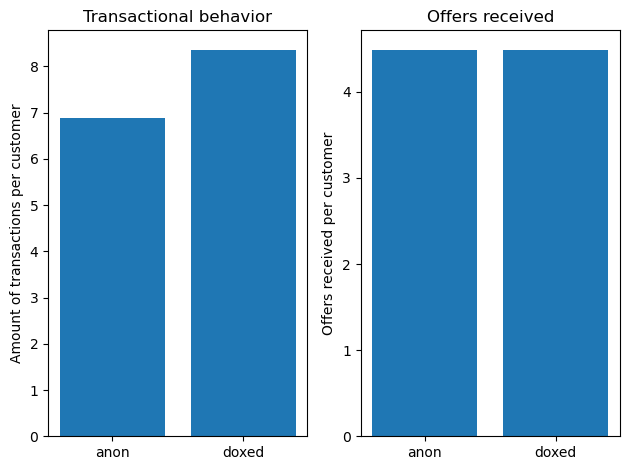

In [1062]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.bar(['anon','doxed'], [transactions_anon, transactions_doxed])
ax1.set_title('Transactional behavior')
ax1.set_ylabel('Amount of transactions per customer')

ax2.bar(['anon','doxed'], [offers_received_anon, offers_received_doxed])
ax2.set_title('Offers received')
ax2.set_ylabel('Offers received per customer')

plt.tight_layout()
plt.show()

As we can see in the plot above the behavior of customers who gave personal information and those who didn't are very similar. They have both roughly the same transactional behavior with 6.89 and 8.36 transactions per customer. However, both parties received exactly the same amount of offers (4.49 per customer in the given period covered by the data), so starbucks apparently didn't take this customer feature into consideration. Lets see if the two groups interact with the offers also in a similar way or maybe different.

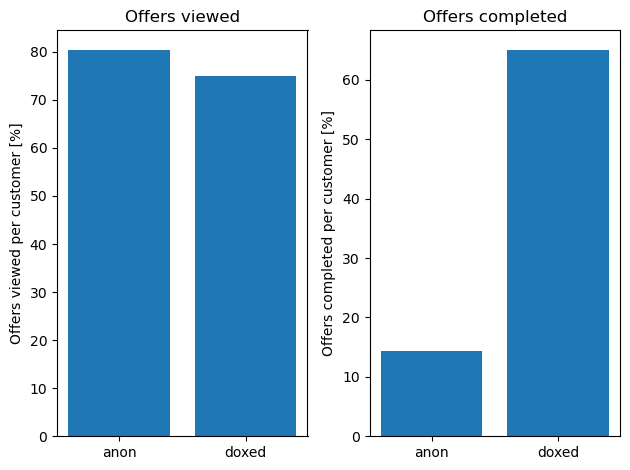

In [1063]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.bar(['anon','doxed'], [offers_viewed_anon, offers_viewed_doxed])
ax1.set_title('Offers viewed')
ax1.set_ylabel('Offers viewed per customer [%]')

ax2.bar(['anon','doxed'], [offers_completed_anon, offers_completed_doxed])
ax2.set_title('Offers completed')
ax2.set_ylabel('Offers completed per customer [%]')

plt.tight_layout()
plt.show()

So the anon and doxed customers both take a look at a high percentage of the received offers, but the anon customers complete these offers significantly less often then the doxed ones (14.43% vs. 65.07%). This could be caused due to a lot of reasons. Maybe you have to give out your personal information to acutally complete an offer? Maybe those customers just don't care to complete the offers they receive? Or maybe they get different kinds of offers? Lets check the last one at least.

In [1064]:
data_anon.offer_type.value_counts()

bogo             7783
discount         7587
informational    3406
Name: offer_type, dtype: int64

In [1065]:
data_doxed.offer_type.value_counts().sum()
data_doxed.offer_type.unique()

array(['bogo', 'discount', 'informational', nan], dtype=object)

In [1066]:
anon_bogo_count = data_anon[data_anon.offer_type == 'bogo'].shape[0]
anon_discount_count = data_anon[data_anon.offer_type == 'discount'].shape[0]
anon_info_count = data_anon[data_anon.offer_type == 'informational'].shape[0]
anon_no_offer_count = data_anon[data_anon.offer_type.isna()].shape[0]

print('Anon data below:')
print(f'Percentage of bogo offers: {round(((anon_bogo_count/data_anon.shape[0])*100),2)}%')
print(f'Percentage of discount offers: {round(((anon_discount_count/data_anon.shape[0])*100),2)}%')
print(f'Percentage of informational offers: {round(((anon_info_count/data_anon.shape[0])*100),2)}%')
print(f'Percentage of customers with no offers: {round(((anon_no_offer_count/data_anon.shape[0])*100),2)}%')

Anon data below:
Percentage of bogo offers: 23.05%
Percentage of discount offers: 22.47%
Percentage of informational offers: 10.09%
Percentage of customers with no offers: 44.4%


In [1067]:
doxed_bogo_count = data_doxed[data_doxed.offer_type == 'bogo'].shape[0]
doxed_discount_count = data_doxed[data_doxed.offer_type == 'discount'].shape[0]
doxed_info_count = data_doxed[data_doxed.offer_type == 'informational'].shape[0]
doxed_no_offer_count = data_doxed[data_doxed.offer_type.isna()].shape[0]

print('Doxed data below:')
print(f'Percentage of bogo offers: {round(((doxed_bogo_count/data_doxed.shape[0])*100),2)}%')
print(f'Percentage of discount offers: {round(((doxed_discount_count/data_doxed.shape[0])*100),2)}%')
print(f'Percentage of informational offers: {round(((doxed_info_count/data_doxed.shape[0])*100),2)}%')
print(f'Percentage of customers with no offers: {round(((doxed_no_offer_count/data_doxed.shape[0])*100),2)}%')

Doxed data below:
Percentage of bogo offers: 23.4%
Percentage of discount offers: 22.84%
Percentage of informational offers: 8.31%
Percentage of customers with no offers: 45.45%


As the percentages above show, both parties received the same kind of offers, with nearly the same percentages compared to the amount of offers sent. We could try to find other differences between the two groups, to maybe pinpoint and find other possible reasons for the big delta in regard of completed offers, but instead lets take this result as a take away and analyse some other features of the dataset.

Lets take a look at the features that we get voluntarily from the customers: Their age, gender and income. Firstly lets analyze the age distribution.

**For the following features analyzed we only use the data from customers who provided us with said data**

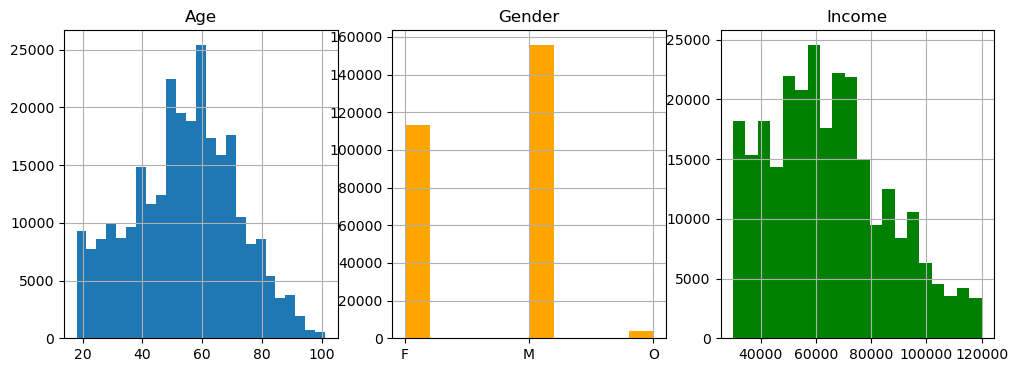

In [1068]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

data_doxed.age.hist(ax=axes[0], bins=25)
axes[0].set_title('Age')

data_doxed.gender.hist(ax=axes[1],color='orange')
axes[1].set_title('Gender')

data_doxed.income.hist(ax=axes[2], bins=20, color='green')
axes[2].set_title('Income')

plt.show()

In the above plots we can see that our customers (which provided us with personal information) are nicely distributed, without any bigger clusters or outliers. Just by looking at the plots we can see that a large portion of these customers is middle-aged, has a good income (nobody earns less than 30k) and is more likely to be male. Lets get some additional numbers though to back that statement.

In [1069]:
age_mean = round(data_doxed.age.mean(), 2)
income_mean = round(data_doxed.income.mean(), 2)
percentage_female = round((data_doxed[data_doxed.gender == 'F'].shape[0] / data_doxed.shape[0])*100,2)
percentage_male = round((data_doxed[data_doxed.gender == 'M'].shape[0] / data_doxed.shape[0])*100,2)
percentage_other = round((data_doxed[data_doxed.gender == 'O'].shape[0] / data_doxed.shape[0])*100,2)

print(f'The mean age of the customers is {age_mean} years.')
print(f'The mean income of the customers is {income_mean} $')
print(f'The cusomters are {percentage_female}% female, {percentage_male}% male and {percentage_other}% identify other genders.')

The mean age of the customers is 53.84 years.
The mean income of the customers is 64337.0 $
The cusomters are 41.47% female, 57.08% male and 1.46% identify other genders.


Now that we have a overview of our general customer database and looked into possible differences between anon and doxed customers, lets get an understanding of the actual offers in regard of their type and how the customers respond to them. For a general understanding and initial reaction to each offer type we can use the data of all customers (anon and doxed).

First we introduce a new column to the dataset, which contains a short description to each offer id:

In [1070]:
data.groupby('offer_id')[['offer_type','reward', 'required_expenditure','duration']].value_counts()

offer_id                          offer_type     reward  required_expenditure  duration
0b1e1539f2cc45b7b9fa7c272da2e1d7  discount       5.0     20.0                  10.0        13751
2298d6c36e964ae4a3e7e9706d1fb8c2  discount       3.0     7.0                   7.0         20139
2906b810c7d4411798c6938adc9daaa5  discount       2.0     10.0                  7.0         15767
3f207df678b143eea3cee63160fa8bed  informational  0.0     0.0                   4.0         11761
4d5c57ea9a6940dd891ad53e9dbe8da0  bogo           10.0    10.0                  5.0         18222
5a8bc65990b245e5a138643cd4eb9837  informational  0.0     0.0                   3.0         14305
9b98b8c7a33c4b65b9aebfe6a799e6d9  bogo           5.0     5.0                   7.0         16202
ae264e3637204a6fb9bb56bc8210ddfd  bogo           10.0    10.0                  7.0         18062
f19421c1d4aa40978ebb69ca19b0e20d  bogo           5.0     5.0                   5.0         19131
fafdcd668e3743c1bb461111dcafc2a4  disco

In [1071]:
offer_mapping = {
    '0b1e1539f2cc45b7b9fa7c272da2e1d7':'20\$ get 5\$ (10d)',
    '2298d6c36e964ae4a3e7e9706d1fb8c2':'7\$ get 3\$ (7d)',
    '2906b810c7d4411798c6938adc9daaa5':'10\$ get 2\$ (7d)',
    '3f207df678b143eea3cee63160fa8bed':'info (4d)',
    '4d5c57ea9a6940dd891ad53e9dbe8da0':'10\$ get 10\$ (5d)',
    '5a8bc65990b245e5a138643cd4eb9837':'info (3d)',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9':'5\$ get 5\$ (7d)',
    'ae264e3637204a6fb9bb56bc8210ddfd':'10\$ get 10\$ (7d)',
    'f19421c1d4aa40978ebb69ca19b0e20d':'5\$ get 5\$ (5d)',
    'fafdcd668e3743c1bb461111dcafc2a4':'10\$ get 2\$ (10d)',
}

In [1072]:
data['offer_description'] = data.offer_id.map(offer_mapping)

In [1073]:
data.head()

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total,gender,age,...,income,reward,required_expenditure,duration,offer_type,email,mobile,social,web,offer_description
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,5\$ get 5\$ (7d)
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,NaN,...,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,20\$ get 5\$ (10d)
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,...,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,10\$ get 2\$ (7d)
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,NaN,...,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,10\$ get 2\$ (10d)
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,NaN,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,10\$ get 10\$ (5d)


For the next steps we only use the data containing information about the offers and filter transactions.

In [1074]:
data_offers = data[data.offer_id.notna()]
data_offers.head()

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total,gender,age,...,income,reward,required_expenditure,duration,offer_type,email,mobile,social,web,offer_description
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,5\$ get 5\$ (7d)
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,NaN,...,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,20\$ get 5\$ (10d)
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,...,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,10\$ get 2\$ (7d)
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,NaN,...,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,10\$ get 2\$ (10d)
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,NaN,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,10\$ get 10\$ (5d)


So first of all: What offers do we have and how many have been sent out to our customers?

In [1075]:
data_offers.offer_type.value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [1076]:
print(f'Bogo offers make up {round((data_offers[data_offers.offer_type == "bogo"].shape[0]/data_offers.shape[0])*100,2)}% of all events.')
print(f'Discount offers make up {round((data_offers[data_offers.offer_type == "discount"].shape[0]/data_offers.shape[0])*100,2)}% of all events.')
print(f'Informational offers make up {round((data_offers[data_offers.offer_type == "informational"].shape[0]/data_offers.shape[0])*100,2)}% of all events.')
print(f'\n{round((data_offers[data_offers.offer_type.isna()].shape[0]/data_offers.shape[0])*100,2)}% of all events are transactions.')

Bogo offers make up 42.74% of all events.
Discount offers make up 41.71% of all events.
Informational offers make up 15.55% of all events.

0.0% of all events are transactions.


In [1077]:
print(f'Bogo offers make up {round((data_offers[data_offers.offer_type == "bogo"].shape[0]/data_offers[data_offers.offer_type.notna()].shape[0])*100,2)}% of all offers.')
print(f'Discount offers make up {round((data_offers[data_offers.offer_type == "discount"].shape[0]/data_offers[data_offers.offer_type.notna()].shape[0])*100,2)}% of all offers.')
print(f'Informational offers make up {round((data_offers[data_offers.offer_type == "informational"].shape[0]/data_offers[data_offers.offer_type.notna()].shape[0])*100,2)}% of all offers.')

Bogo offers make up 42.74% of all offers.
Discount offers make up 41.71% of all offers.
Informational offers make up 15.55% of all offers.


Now lets take a look at each individual offer type. How well are they perceived?

In [1078]:
data_offers.groupby('offer_id')[['offer_type','reward', 'required_expenditure','duration']].value_counts()

offer_id                          offer_type     reward  required_expenditure  duration
0b1e1539f2cc45b7b9fa7c272da2e1d7  discount       5.0     20.0                  10.0        13751
2298d6c36e964ae4a3e7e9706d1fb8c2  discount       3.0     7.0                   7.0         20139
2906b810c7d4411798c6938adc9daaa5  discount       2.0     10.0                  7.0         15767
3f207df678b143eea3cee63160fa8bed  informational  0.0     0.0                   4.0         11761
4d5c57ea9a6940dd891ad53e9dbe8da0  bogo           10.0    10.0                  5.0         18222
5a8bc65990b245e5a138643cd4eb9837  informational  0.0     0.0                   3.0         14305
9b98b8c7a33c4b65b9aebfe6a799e6d9  bogo           5.0     5.0                   7.0         16202
ae264e3637204a6fb9bb56bc8210ddfd  bogo           10.0    10.0                  7.0         18062
f19421c1d4aa40978ebb69ca19b0e20d  bogo           5.0     5.0                   5.0         19131
fafdcd668e3743c1bb461111dcafc2a4  disco

In [1079]:
data_offers[data_offers.offer_type == 'bogo'][['offer_received','offer_viewed', 'offer_completed']].value_counts()
data_offers[data_offers.offer_type == 'discount'][['offer_received','offer_viewed', 'offer_completed']].value_counts()
data_offers[data_offers.offer_type == 'informational'][['offer_received','offer_viewed', 'offer_completed']].value_counts()

offer_received  offer_viewed  offer_completed
1               0             0                  15235
0               1             0                  10831
dtype: int64

In [1080]:
for type in data_offers.offer_type.unique():
    print(type)

bogo
discount
informational


In [1081]:
bogo_received = data_offers[data_offers.offer_type == 'bogo'].offer_received.sum()
bogo_viewed = data_offers[data_offers.offer_type == 'bogo'].offer_viewed.sum()
bogo_completed = data_offers[data_offers.offer_type == 'bogo'].offer_completed.sum()
discount_received = data_offers[data_offers.offer_type == 'discount'].offer_received.sum()
discount_viewed = data_offers[data_offers.offer_type == 'discount'].offer_viewed.sum()
discount_completed = data_offers[data_offers.offer_type == 'discount'].offer_completed.sum()
informational_received = data_offers[data_offers.offer_type == 'informational'].offer_received.sum()
informational_viewed = data_offers[data_offers.offer_type == 'informational'].offer_viewed.sum()
informational_completed = data_offers[data_offers.offer_type == 'informational'].offer_completed.sum()

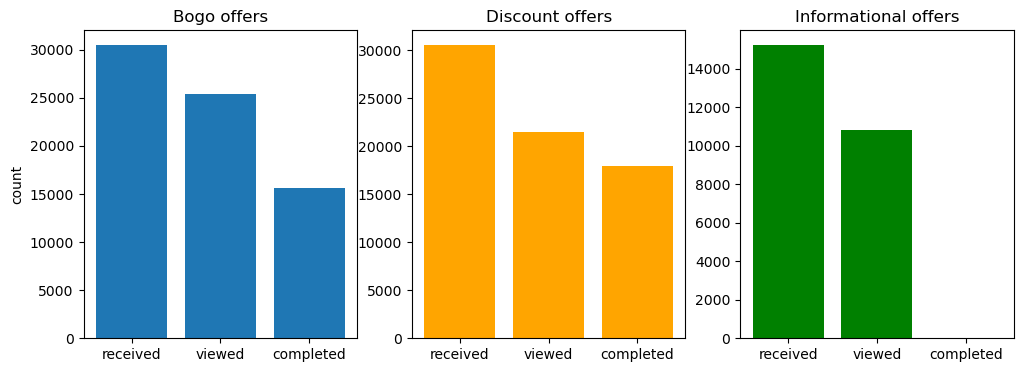

In [1082]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.bar(['received', 'viewed', 'completed'], [bogo_received, bogo_viewed, bogo_completed]);
ax1.set_title('Bogo offers');
ax1.set_ylabel('count')

ax2.bar(['received', 'viewed', 'completed'], [discount_received, discount_viewed, discount_completed], color='orange');
ax2.set_title('Discount offers');

ax3.bar(['received', 'viewed', 'completed'], [informational_received, informational_viewed, informational_completed], color='green');
ax3.set_title('Informational offers');

In [1083]:
print(f'Bogo-stats:')
print(f'{round((bogo_viewed/bogo_received)*100, 2)}% of all received Bogo offers are viewed and {round((bogo_completed/bogo_viewed)*100,2)}% of the viewed ones were completed.')

print(f'\nDiscount-stats:')
print(f'{round((discount_viewed/discount_received)*100, 2)}% of all received discount offers are viewed and {round((discount_completed/discount_viewed)*100,2)}% of the viewed ones were completed.')

print(f'\nInformational-stats:')
print(f'{round((informational_viewed/informational_received)*100, 2)}% of all received informational offers are viewed and {round((informational_completed/informational_viewed)*100,2)}% of the viewed ones were completed.')

Bogo-stats:
83.44% of all received Bogo offers are viewed and 61.57% of the viewed ones were completed.

Discount-stats:
70.21% of all received discount offers are viewed and 83.52% of the viewed ones were completed.

Informational-stats:
71.09% of all received informational offers are viewed and 0.0% of the viewed ones were completed.


So as we can see above all offer types are viewed with a high percentage of >70% of all offers sent, with bogo-offers getting viewed slightly more often with >80%. However, of all bogo-offers viewed only around 60% get completed, while discount-offers get completed by 83%. Maybe thats caused due to higher barriers/initial investments for getting a reward.

Now lets analyze each type of 'Bogo' and 'Discount' offer. We skip the informational offers for now, since they only get viewed and there is no direct way to measure an impact on the spending behavior of the customers.

In [1084]:
data_offers.head()

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total,gender,age,...,income,reward,required_expenditure,duration,offer_type,email,mobile,social,web,offer_description
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,5\$ get 5\$ (7d)
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,NaN,...,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,20\$ get 5\$ (10d)
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,...,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,10\$ get 2\$ (7d)
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,NaN,...,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,10\$ get 2\$ (10d)
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,NaN,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,10\$ get 10\$ (5d)


In [1085]:
bogo_offers_received = data_offers[(data_offers.offer_type == 'bogo') & (data_offers.offer_received == 1)][['offer_id','offer_description']].value_counts()
discount_offers_received = data_offers[(data_offers.offer_type == 'discount') & (data_offers.offer_received == 1)][['offer_id','offer_description']].value_counts()
informational_offers_received = data_offers[(data_offers.offer_type == 'informational') & (data_offers.offer_received == 1)][['offer_id','offer_description']].value_counts()

In [1086]:
bogo_offers_viewed = data_offers[(data_offers.offer_type == 'bogo') & (data_offers.offer_viewed == 1)][['offer_id','offer_description']].value_counts()
discount_offers_viewed = data_offers[(data_offers.offer_type == 'discount') & (data_offers.offer_viewed == 1)][['offer_id','offer_description']].value_counts()
informational_offers_viewed = data_offers[(data_offers.offer_type == 'informational') & (data_offers.offer_viewed == 1)][['offer_id','offer_description']].value_counts()

In [1087]:
bogo_offers_completed = data_offers[(data_offers.offer_type == 'bogo') & (data_offers.offer_completed == 1)][['offer_id','offer_description']].value_counts()
discount_offers_completed = data_offers[(data_offers.offer_type == 'discount') & (data_offers.offer_completed == 1)][['offer_id','offer_description']].value_counts()
informational_offers_completed = data_offers[(data_offers.offer_type == 'informational') & (data_offers.offer_completed == 1)][['offer_id','offer_description']].value_counts()

bogo_offers_completed

offer_id                          offer_description 
9b98b8c7a33c4b65b9aebfe6a799e6d9  5\$ get 5\$ (7d)      4354
f19421c1d4aa40978ebb69ca19b0e20d  5\$ get 5\$ (5d)      4296
ae264e3637204a6fb9bb56bc8210ddfd  10\$ get 10\$ (7d)    3688
4d5c57ea9a6940dd891ad53e9dbe8da0  10\$ get 10\$ (5d)    3331
dtype: int64

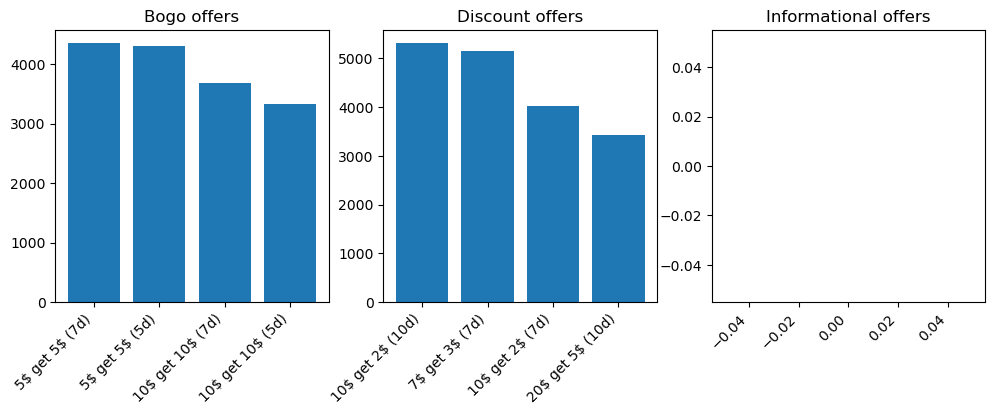

In [1088]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

ax1.bar(bogo_offers_completed.index.get_level_values(1), bogo_offers_completed.values);
ax1.set_title('Bogo offers')

ax2.bar(discount_offers_completed.index.get_level_values(1), discount_offers_completed.values);
ax2.set_title('Discount offers')

ax3.bar(informational_offers_completed.index.get_level_values(1), informational_offers_completed.values);
ax3.set_title('Informational offers')

fig.autofmt_xdate(rotation=45)

As we can see in the above plots there is a difference between each kind of offer in a specific offer category. It seems that offers that require a lower initial investment are more frequently completed. Lets look into each category by itself.

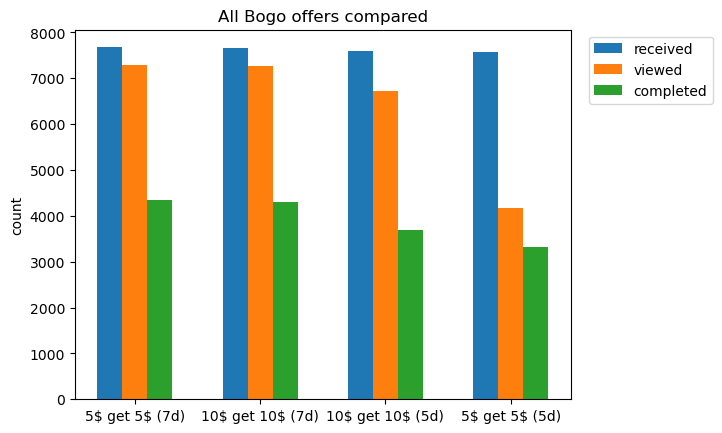

In [1089]:
fig, ax = plt.subplots()

x = np.arange(len(bogo_offers_received))
bar_width = 0.2

labels = bogo_offers_received.index.get_level_values(1)

ax.bar(x, bogo_offers_received.values, width=bar_width);
ax.bar((x+bar_width), bogo_offers_viewed.values, width=bar_width);
ax.bar((x+2*bar_width), bogo_offers_completed.values, width=bar_width);

plt.title('All Bogo offers compared')
plt.ylabel('count')

tick_positions = x+bar_width
plt.xticks(tick_positions, bogo_offers_received.index.get_level_values(1));
plt.legend(['received','viewed','completed'], loc='upper right', bbox_to_anchor=(1.3,1));

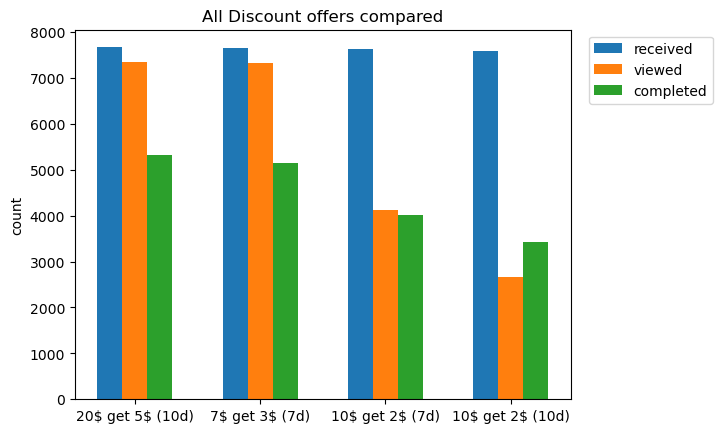

In [1090]:
fig, ax = plt.subplots()

x = np.arange(len(discount_offers_received))
bar_width = 0.2

labels = discount_offers_received.index.get_level_values(1)

ax.bar(x, discount_offers_received.values, width=bar_width);
ax.bar((x+bar_width), discount_offers_viewed.values, width=bar_width);
ax.bar((x+2*bar_width), discount_offers_completed.values, width=bar_width);

plt.title('All Discount offers compared')
plt.ylabel('count')

tick_positions = x+bar_width
plt.xticks(tick_positions, discount_offers_received.index.get_level_values(1));
plt.legend(['received','viewed','completed'], loc='upper right', bbox_to_anchor=(1.3,1));

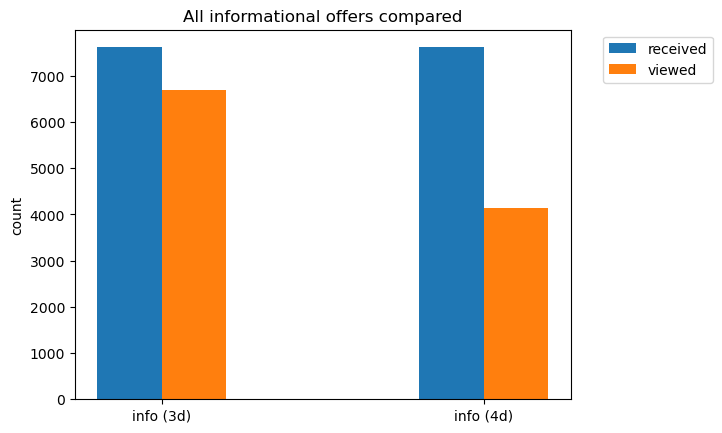

In [1091]:
fig, ax = plt.subplots()

x = np.arange(len(informational_offers_received))
bar_width = 0.2

labels = informational_offers_received.index.get_level_values(1)

ax.bar(x, informational_offers_received.values, width=bar_width);
ax.bar((x+bar_width), informational_offers_viewed.values, width=bar_width);

plt.title('All informational offers compared')
plt.ylabel('count')

tick_positions = x+0.5*bar_width
plt.xticks(tick_positions, informational_offers_received.index.get_level_values(1));
plt.legend(['received','viewed'], loc='upper right', bbox_to_anchor=(1.3,1));

Next we look if we can find some hints which customers tend to complete an offer they received and which don't. Therefore we can look at features like age, income and gender. Additionally we can analyze if certain ways of contact lead to more offer acceptance than others.

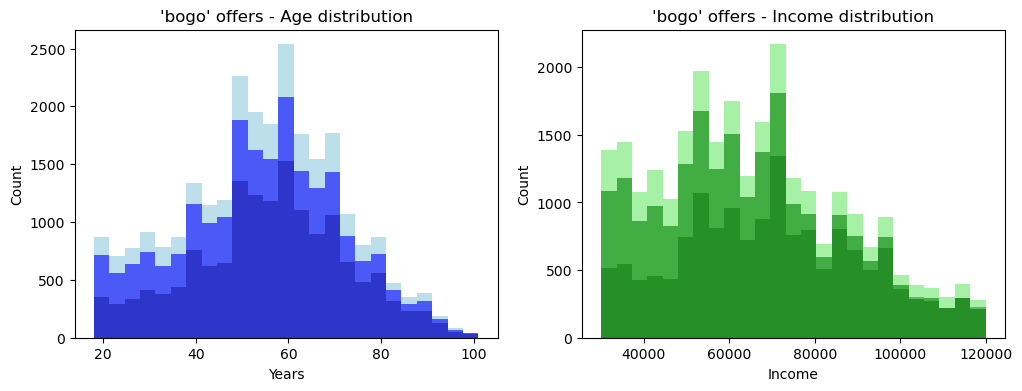

In [1092]:
bogo_received = data_doxed[(data_doxed.offer_type == 'bogo') & (data_doxed.offer_received == 1)]
bogo_viewed = data_doxed[(data_doxed.offer_type == 'bogo') & (data_doxed.offer_viewed == 1)]
bogo_completed = data_doxed[(data_doxed.offer_type == 'bogo') & (data_doxed.offer_completed == 1)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.hist(bogo_received.age, bins=25, alpha=0.8, color='lightblue')
ax1.hist(bogo_viewed.age, bins=25, alpha=0.6, color='blue')
ax1.hist(bogo_completed.age, bins=25, alpha=0.4, color='darkblue');
ax1.set_title("'bogo' offers - Age distribution");
ax1.set_ylabel('Count');
ax1.set_xlabel('Years');

ax2.hist(bogo_received.income, bins=25, alpha=0.8, color='lightgreen')
ax2.hist(bogo_viewed.income, bins=25, alpha=0.6, color='green')
ax2.hist(bogo_completed.income, bins=25, alpha=0.4, color='darkgreen');
ax2.set_title("'bogo' offers - Income distribution");
ax2.set_ylabel('Count');
ax2.set_xlabel('Income');

What we can see above is that the 'bogo' offers received, viewed and completed are fairly evenly distributed age-wise compared to the general age distribution of all doxed customers. If we take a look on the income distribution it seems that customers with a lover income tend to complete the 'bogo' offers less than customers with a much higher income.

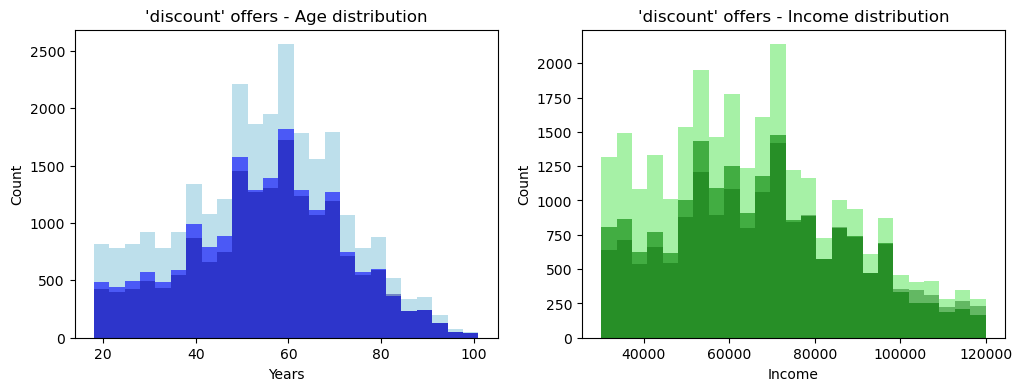

In [1093]:
discount_received = data_doxed[(data_doxed.offer_type == 'discount') & (data_doxed.offer_received == 1)]
discount_viewed = data_doxed[(data_doxed.offer_type == 'discount') & (data_doxed.offer_viewed == 1)]
discount_completed = data_doxed[(data_doxed.offer_type == 'discount') & (data_doxed.offer_completed == 1)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.hist(discount_received.age, bins=25, alpha=0.8, color='lightblue')
ax1.hist(discount_viewed.age, bins=25, alpha=0.6, color='blue')
ax1.hist(discount_completed.age, bins=25, alpha=0.4, color='darkblue');
ax1.set_title("'discount' offers - Age distribution");
ax1.set_ylabel('Count');
ax1.set_xlabel('Years');

ax2.hist(discount_received.income, bins=25, alpha=0.8, color='lightgreen')
ax2.hist(discount_viewed.income, bins=25, alpha=0.6, color='green')
ax2.hist(discount_completed.income, bins=25, alpha=0.4, color='darkgreen');
ax2.set_title("'discount' offers - Income distribution");
ax2.set_ylabel('Count');
ax2.set_xlabel('Income');

Looking at the discount offers we can see something similar for the income distribution. Wealthier customers tend to complete the discount offers more often. Additionally we can see here that most customers who viewed their discount offer also completed it.

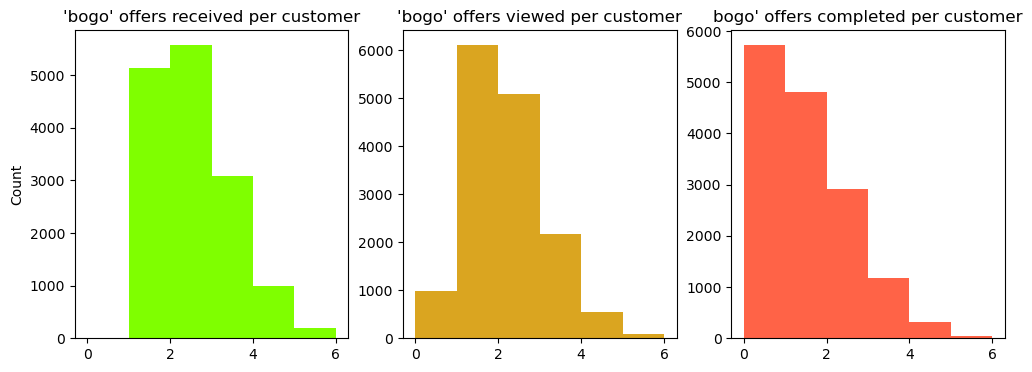

In [1094]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

received = data_offers[data_offers.offer_type == 'bogo'].groupby('customer_id')['offer_received'].sum()
viewed = data_offers[data_offers.offer_type == 'bogo'].groupby('customer_id')['offer_viewed'].sum()
completed = data_offers[data_offers.offer_type == 'bogo'].groupby('customer_id')['offer_completed'].sum()

bin_edges = np.histogram_bin_edges(np.concatenate((received, viewed, completed)), bins=6)

ax1.hist(received, bins=bin_edges, alpha=1, color='chartreuse');
ax1.set_title("'bogo' offers received per customer");
ax1.set_ylabel('Count')

ax2.hist(viewed, bins=bin_edges, alpha=1, color='goldenrod');
ax2.set_title("'bogo' offers viewed per customer");

ax3.hist(completed, bins=bin_edges, alpha=1, color='tomato');
ax3.set_title("bogo' offers completed per customer");

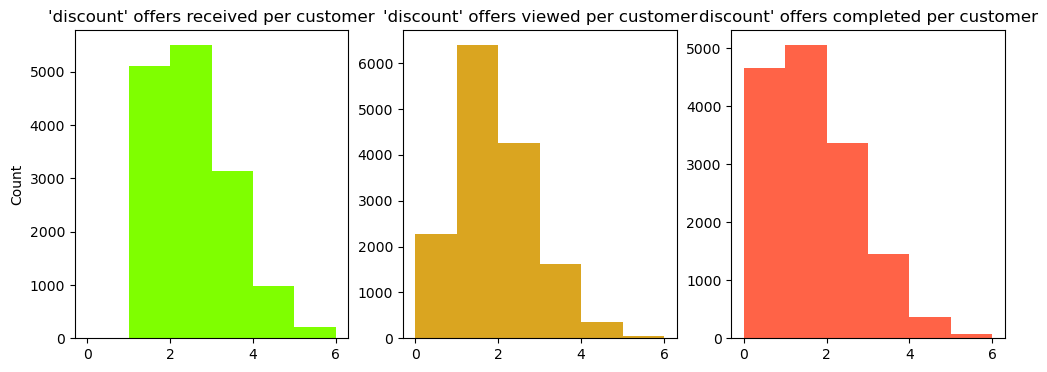

In [1095]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

received = data_offers[data_offers.offer_type == 'discount'].groupby('customer_id')['offer_received'].sum()
viewed = data_offers[data_offers.offer_type == 'discount'].groupby('customer_id')['offer_viewed'].sum()
completed = data_offers[data_offers.offer_type == 'discount'].groupby('customer_id')['offer_completed'].sum()

bin_edges = np.histogram_bin_edges(np.concatenate((received, viewed, completed)), bins=6)

ax1.hist(received, bins=bin_edges, alpha=1, color='chartreuse');
ax1.set_title("'discount' offers received per customer");
ax1.set_ylabel('Count')

ax2.hist(viewed, bins=bin_edges, alpha=1, color='goldenrod');
ax2.set_title("'discount' offers viewed per customer");

ax3.hist(completed, bins=bin_edges, alpha=1, color='tomato');
ax3.set_title("discount' offers completed per customer");

As expected we can summarize that the typical pattern of x amount offers received, a fraction of that viewed and another fraction of that is completed is given for both, 'bogo' and 'discount' offers.

***

### Section 3 - Model

In this part of the project we want to train a model to be able to predict which kind of advertisement is best for a given customer with specific traits and features. So therefore we basically want to know if we should send the new customer a 'bogo', 'discount' or an informational offer.

1) Preparing the data for training the model

First of all we need to specify our features and target values.

Since we want to use personal information for our training, we go directly with the doxed dataset, which only contains data including personal information.

In [1096]:
data_model = data_doxed.copy()

In [1097]:
data_model.columns

Index(['customer_id', 'time', 'offer_completed', 'offer_received',
       'offer_viewed', 'transaction', 'offer_id', 'total', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'required_expenditure',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web'],
      dtype='object')

In [1098]:
data_model.drop(columns=['customer_id','reward','required_expenditure','duration','offer_type'], inplace=True)

In [1099]:
data_model.columns

Index(['time', 'offer_completed', 'offer_received', 'offer_viewed',
       'transaction', 'offer_id', 'total', 'gender', 'age', 'became_member_on',
       'income', 'email', 'mobile', 'social', 'web'],
      dtype='object')

In [1100]:
data_model.head()

,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total,gender,age,became_member_on,income,email,mobile,social,web
0,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,20170509,100000.0,1.0,1.0,0.0,1.0
2,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,20180426,70000.0,1.0,1.0,0.0,1.0
5,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,65.0,20180209,53000.0,1.0,1.0,1.0,1.0
7,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,M,58.0,20171111,51000.0,1.0,1.0,0.0,1.0
8,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,61.0,20170911,57000.0,1.0,0.0,0.0,1.0


In [1101]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time              272762 non-null  int64  
 1   offer_completed   272762 non-null  int64  
 2   offer_received    272762 non-null  int64  
 3   offer_viewed      272762 non-null  int64  
 4   transaction       272762 non-null  int64  
 5   offer_id          148805 non-null  object 
 6   total             156401 non-null  float64
 7   gender            272762 non-null  object 
 8   age               272762 non-null  float64
 9   became_member_on  272762 non-null  int64  
 10  income            272762 non-null  float64
 11  email             148805 non-null  float64
 12  mobile            148805 non-null  float64
 13  social            148805 non-null  float64
 14  web               148805 non-null  float64
dtypes: float64(7), int64(6), object(2)
memory usage: 33.3+ MB


Data preparations ToDo:
*   fill in all missing values
*   map 'offer_id' to a simple number format
*   convert all float to int format
*   change the 'became_member_on' to 'became_member_in_year' to simplify things

In [1102]:
data_model.isna().sum()

time                     0
offer_completed          0
offer_received           0
offer_viewed             0
transaction              0
offer_id            123957
total               116361
gender                   0
age                      0
became_member_on         0
income                   0
email               123957
mobile              123957
social              123957
web                 123957
dtype: int64

In [1103]:
data_model[
    (data_model.transaction.notna()) &
    (data_model.offer_id.isna()) &
    (data_model.mobile.isna()) &
    (data_model.email.isna()) &
    (data_model.social.isna()) &
    (data_model.web.isna())
    ].shape[0]

123957

In [1104]:
data_model[(data_model.total.isna())&(data_model.offer_id.notna())].shape[0]

116361

In [1105]:
data_model.fillna(0,inplace=True)

In [1106]:
data_model.isna().sum()

time                0
offer_completed     0
offer_received      0
offer_viewed        0
transaction         0
offer_id            0
total               0
gender              0
age                 0
became_member_on    0
income              0
email               0
mobile              0
social              0
web                 0
dtype: int64

Now we can change all columns of type float to type int.

In [1107]:
data_model[['total','age','income','email','mobile','social','web']] = data_model[['total','age','income','email','mobile','social','web']].astype(int)

In [1108]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   time              272762 non-null  int64 
 1   offer_completed   272762 non-null  int64 
 2   offer_received    272762 non-null  int64 
 3   offer_viewed      272762 non-null  int64 
 4   transaction       272762 non-null  int64 
 5   offer_id          272762 non-null  object
 6   total             272762 non-null  int64 
 7   gender            272762 non-null  object
 8   age               272762 non-null  int64 
 9   became_member_on  272762 non-null  int64 
 10  income            272762 non-null  int64 
 11  email             272762 non-null  int64 
 12  mobile            272762 non-null  int64 
 13  social            272762 non-null  int64 
 14  web               272762 non-null  int64 
dtypes: int64(13), object(2)
memory usage: 33.3+ MB


In [1109]:
data_model.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '2906b810c7d4411798c6938adc9daaa5',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '3f207df678b143eea3cee63160fa8bed',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '5a8bc65990b245e5a138643cd4eb9837', 0], dtype=object)

And exchange the offer_ids with simple integers via mapping.

In [1110]:
offer_id_mapping = {
    0:0,                                    # we filled all missing values with zeros. Now, 0 represents a transaction event.
    '0b1e1539f2cc45b7b9fa7c272da2e1d7':1,
    '2298d6c36e964ae4a3e7e9706d1fb8c2':2,
    '2906b810c7d4411798c6938adc9daaa5':3,
    '3f207df678b143eea3cee63160fa8bed':4,
    '4d5c57ea9a6940dd891ad53e9dbe8da0':5,
    '5a8bc65990b245e5a138643cd4eb9837':6,
    '9b98b8c7a33c4b65b9aebfe6a799e6d9':7,
    'ae264e3637204a6fb9bb56bc8210ddfd':8,
    'f19421c1d4aa40978ebb69ca19b0e20d':9,
    'fafdcd668e3743c1bb461111dcafc2a4':10,
}

In [1111]:
data_model.offer_id = data_model.offer_id.map(offer_id_mapping)

In [1112]:
gender_mapping = {
    'M':0,
    'F':1,
    'O':2
}

In [1113]:
data_model.gender = data_model.gender.map(gender_mapping)

In [1114]:
data_model.became_member_on = data_model.became_member_on.astype(str)
data_model['became_member_in'] = data_model.became_member_on.str[:4].astype(int)
data_model.drop(columns=['became_member_on'], inplace=True)

In [1115]:
data_model.head()

,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,total,gender,age,income,email,mobile,social,web,became_member_in
0,0,0,1,0,0,7,0,1,75,100000,1,1,0,1,2017
2,0,0,1,0,0,3,0,0,68,70000,1,1,0,1,2018
5,0,0,1,0,0,9,0,0,65,53000,1,1,1,1,2018
7,0,0,1,0,0,4,0,0,58,51000,1,1,0,1,2017
8,0,0,1,0,0,1,0,1,61,57000,1,0,0,1,2017


2) Splitting and scaling the data:

First we split our data into the feature variables X and the target value Y.

In [1116]:
X = data_model.drop(columns=['offer_id'])
y = data_model.offer_id

Since we probably end up using a linear regression model (since we want to predict a categorical value), we should scale our data so all values are between 0 and 1. Luckily we can use a method out of the sklearn.preprocessing module:

In [1117]:
cols = X.columns.tolist()

scaler = MinMaxScaler()
X[cols] = scaler.fit_transform(X[cols])

In [1118]:
X.head()

,time,offer_completed,offer_received,offer_viewed,transaction,total,gender,age,income,email,mobile,social,web,became_member_in
0,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.686747,0.777778,1.0,1.0,0.0,1.0,0.8
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.602410,0.444444,1.0,1.0,0.0,1.0,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.566265,0.255556,1.0,1.0,1.0,1.0,1.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.481928,0.233333,1.0,1.0,0.0,1.0,0.8
8,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.518072,0.300000,1.0,0.0,0.0,1.0,0.8
